In [94]:
import numpy as np
import matplotlib.pyplot as plt

lines = []
with open("logs/jog3.txt", "r") as f:
    lines = f.readlines()

data = []
for line in lines:
    line = line.strip('\n').split(',')
    data.append(line)
data = np.array(data, dtype=np.float32)
x_acc, y_acc, z_acc, x_ang, y_ang, z_ang, t = data[:, 0],data[:, 1], data[:, 2], data[:, 3], data[:, 4], data[:, 5], data[:,6]*0.001
print(data.shape)

# Sampling Rate
rec_time = t[-1]-t[0]
s = data.shape[0]/rec_time
print(f"{s} Hz")

(15201, 7)
191.4604091188725 Hz


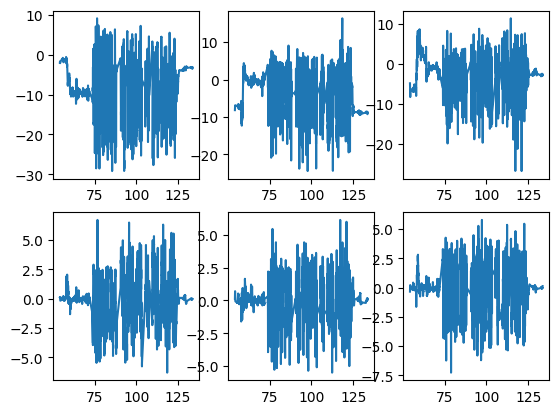

In [95]:
def plotFigs():
    fig, axes = plt.subplots(nrows=2, ncols=3)
    axes[0,0].plot(t,x_acc)
    axes[0,1].plot(t,y_acc)
    axes[0, 2].plot(t,z_acc)
    axes[1, 0].plot(t,x_ang)
    axes[1, 1].plot(t,y_ang)
    axes[1, 2].plot(t,z_ang)

    plt.show()

plotFigs()

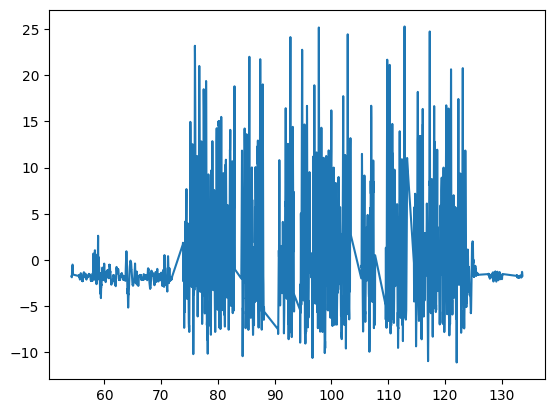

In [96]:
def ProcessData():
    # Data collection Phase
    mag = np.sqrt(pow(x_acc,2)+pow(y_acc,2)+pow(z_acc,2))
    avgmag = np.average(mag)
    netmag = mag-avgmag
    return netmag

netmag = ProcessData()
plt.plot(t, netmag)
plt.show()


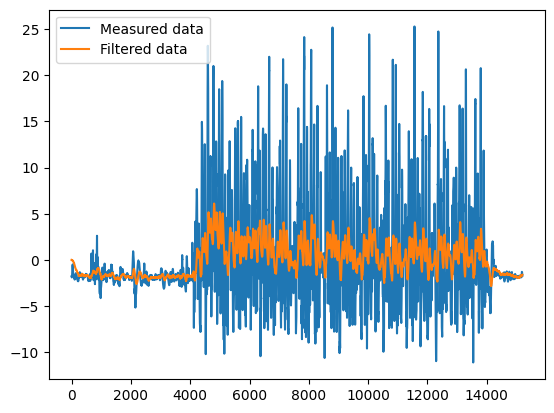

In [97]:
# Define the state transition model
def transition_model(x, dt):
    return x

# Define the observation model
def observation_model(x):
    return x + np.random.randn()

# Define the Kalman filter function
def kalman_filter(data, Q, R, x0, P0):
    n = len(data)
    x_pred = np.zeros(n)
    x_filt = np.zeros(n)
    P_pred = np.zeros(n)
    P_filt = np.zeros(n)
    K = np.zeros(n)

    # Initialization
    x_pred[0] = x0
    P_pred[0] = P0

    for i in range(1, n):
        # Prediction step
        x_pred[i] = transition_model(x_filt[i-1], 1)
        P_pred[i] = P_filt[i-1] + Q

        # Update step
        K[i] = P_pred[i] / (P_pred[i] + R)
        x_filt[i] = x_pred[i] + K[i] * (data[i] - observation_model(x_pred[i]))
        P_filt[i] = (1 - K[i]) * P_pred[i]

    return x_filt

# Set parameters for the Kalman filter
Q = 1e-5  # process noise covariance
R = 0.1  # measurement noise covariance
x0 = netmag[0]  # initial state
P0 = 1  # initial state covariance

# Apply the Kalman filter
filt_mag = kalman_filter(netmag, Q, R, x0, P0)
# filt_x = kalman_filter(x_acc, Q, R, x0, P0)
# filt_y = kalman_filter(y_acc, Q, R, x0, P0)
# filt_z = kalman_filter(z_acc, Q, R, x0, P0)


# plotgraphs = [[x_acc, filt_x], [y_acc, filt_y], [z_acc, filt_z], ]
# for l in plotgraphs:
#     plt.plot(l[0], label='Measured data')
#     plt.plot(l[1], label='Filtered data')
#     plt.legend()
#     plt.show()

# Plot the results
plt.plot(netmag, label='Measured data')
plt.plot(filt_mag, label='Filtered data')
plt.legend()
plt.show()

avg: 0.031434562856480476, std:1.79711305733691, var:3.229615340850816, max:6.108136805291977
Jogging Step Count: 48
First Jogging Peak: 25.101795311719442
Walking Step Count: 80
First Walking Peak: 22.161239597924595


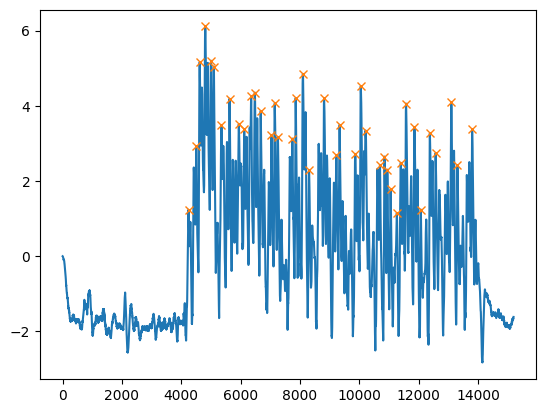

In [98]:
# Peak Detection Phase
from scipy.signal import find_peaks

var = np.var(filt_mag)
avg = np.average(filt_mag)
sd = np.std(filt_mag)
maxi = np.max(filt_mag)
print(f"avg: {avg}, std:{sd}, var:{var}, max:{maxi}")
start_vector = filt_mag[:3]

# Jogging
Jogpeaks, _ = find_peaks(filt_mag, prominence=2*(avg+sd))
print(f"Jogging Step Count: {2*len(Jogpeaks)}")
print(f"First Jogging Peak: {Jogpeaks[0]/s}")

# Walking
Walkpeaks, _ = find_peaks(filt_mag, prominence=1.5*(avg+sd))
print(f"Walking Step Count: {2*len(Walkpeaks)}")
print(f"First Walking Peak: {Walkpeaks[0]/s}")


plt.plot(filt_mag)
plt.plot(Walkpeaks, filt_mag[Walkpeaks], "x")
plt.show()

# plt.plot(filt_mag)
# plt.plot(Jogpeaks, filt_mag[Jogpeaks], "x")
# plt.show()